In [6]:
import os
import sys
import cv2
import numpy as np
import random
from tqdm import tqdm
from pathlib import Path
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [7]:
class WiderFaceParser:

    def __init__(self, txt_path):
        self.imgs_path = []
        self.words = []

        with open(txt_path, 'r') as f:
            lines = f.readlines()

        is_first_line = True
        labels = []
        for line in lines:
            line = line.rstrip()
            if line.startswith('#'):
                if not is_first_line:
                    self.words.append(labels.copy())
                    labels.clear()

                path = line[2:]
                base_dir = os.path.dirname(txt_path)
                img_path = os.path.join(base_dir, 'images', path)
                self.imgs_path.append(img_path)
                is_first_line = False
            else:
                line = line.split(' ')
                label = [float(x) for x in line[:4]]
                labels.append(label)

        self.words.append(labels)

def convert_to_yolo_format(img_path, labels, output_dir):

    try:
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not read image {img_path}")
            return

        h, w, _ = img.shape

        yolo_labels = []
        for label in labels:
            x1, y1, box_w, box_h = label

            x1 = max(0, x1)
            y1 = max(0, y1)
            box_w = min(w - 1 - x1, box_w)
            box_h = min(h - 1 - y1, box_h)

            if box_w <= 0 or box_h <= 0:
                continue

            cx = (x1 + box_w / 2) / w
            cy = (y1 + box_h / 2) / h
            norm_w = box_w / w
            norm_h = box_h / h

            yolo_labels.append(f"0 {cx:.6f} {cy:.6f} {norm_w:.6f} {norm_h:.6f}\n")

        img_name = os.path.basename(img_path)
        label_name = os.path.splitext(img_name)[0] + ".txt"

        img_output_path = os.path.join(output_dir, "images", img_name)
        label_output_path = os.path.join(output_dir, "labels", label_name)

        # Ensure parent directories exist
        os.makedirs(os.path.dirname(img_output_path), exist_ok=True)
        os.makedirs(os.path.dirname(label_output_path), exist_ok=True)

        cv2.imwrite(img_output_path, img)
        with open(label_output_path, "w") as f:
            f.writelines(yolo_labels)
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

def main():

    raw_dir = 'drive/MyDrive/4.2/yolov8-face-detection/datasets/widerface_raw'
    output_dir = Path('datasets/widerface_yolo')

    train_txt_path = os.path.join(raw_dir, "WIDER_train", "wider_face_train_bbx_gt.txt")

    if not os.path.exists(train_txt_path):
        print(f"Error: Annotation file not found at '{train_txt_path}'")
        print("Please check your directory structure and ensure the file exists.")
        return

    print("Parsing WIDER FACE annotations...")
    parser = WiderFaceParser(train_txt_path)

    dataset = list(zip(parser.imgs_path, parser.words))
    random.seed(42) # for reproducible splits
    random.shuffle(dataset)

    split_index = int(len(dataset) * 0.8)
    train_set = dataset[:split_index]
    val_set = dataset[split_index:]

    print(f"Total images: {len(dataset)}")
    print(f"Training set size: {len(train_set)}")
    print(f"Validation set size: {len(val_set)}")

    for split_name in ["train", "val"]:
        os.makedirs(output_dir / split_name / "images", exist_ok=True)
        os.makedirs(output_dir / split_name / "labels", exist_ok=True)

    print("\nProcessing training set...")
    for img_path, labels in tqdm(train_set, desc="Training Set"):
        convert_to_yolo_format(img_path, labels, str(output_dir / "train"))

    print("\nProcessing validation set...")
    for img_path, labels in tqdm(val_set, desc="Validation Set"):
        convert_to_yolo_format(img_path, labels, str(output_dir / "val"))

    print(f"\nData preparation complete. Output dataset saved to: {output_dir}")

if __name__ == '__main__':
    main()

Parsing WIDER FACE annotations...
Total images: 12880
Training set size: 10304
Validation set size: 2576

Processing training set...


Training Set:  10%|▉         | 1000/10304 [00:21<02:46, 55.99it/s]

Training Set:  57%|█████▋    | 5845/10304 [01:43<01:06, 67.44it/s]

Training Set:  70%|██████▉   | 7178/10304 [02:04<01:01, 50.87it/s]

Training Set:  72%|███████▏  | 7457/10304 [02:09<00:40, 69.49it/s]

Training Set:  74%|███████▎  | 7599/10304 [02:11<00:39, 67.68it/s]

Training Set:  74%|███████▍  | 7638/10304 [02:12<00:39, 66.67it/s]

Training Set:  88%|████████▊ | 9062/10304 [02:35<00:17, 70.06it/s]

Training Set:  95%|█████████▌| 9821/10304 [02:47<00:08, 54.94it/s]

Training Set: 100%|██████████| 10304/10304 [02:54<00:00, 59.01it/s]



Processing validation set...


Validation Set:   2%|▏         | 47/2576 [00:00<00:32, 77.20it/s]

Validation Set:  12%|█▏        | 300/2576 [00:04<00:36, 62.16it/s]

Validation Set:  95%|█████████▌| 2451/2576 [00:38<00:01, 74.90it/s]

Validation Set: 100%|██████████| 2576/2576 [00:40<00:00, 63.97it/s]


Data preparation complete. Output dataset saved to: datasets/widerface_yolo


In [8]:
model = YOLO('yolov8n.pt')

# 2. Train the model on the WIDER FACE dataset
# The .train() method returns a results object, but the model object
# itself is updated in-place with the results of the training.
print("\n--- Starting Training ---\n")
model.train(
    data='widerface.yaml',
    epochs=5,
    imgsz=640,
    name='yolov8n_widerface_run'
)
print("\n--- Training Finished ---\n")


# 3. Evaluate the best model on the validation set
# After training, the `model` object automatically loads the best weights,
# so we can directly call the .val() method.
print("\n--- Starting Evaluation ---\n")
metrics = model.val()
print("\n--- Evaluation Finished ---\n")

# 4. Print the key metrics
print("Key Evaluation Metrics:")
print(f"  mAP50-95 (Box): {metrics.box.map:.4f}")
print(f"  mAP50 (Box):    {metrics.box.map50:.4f}")

100%|██████████| 6.25M/6.25M [00:00<00:00, 330MB/s]



--- Starting Training ---

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=widerface.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_widerface_run, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plot

100%|██████████| 755k/755k [00:00<00:00, 139MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 173MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2373.6±1462.0 MB/s, size: 195.4 KB)


train: Scanning /content/datasets/widerface_yolo/train/labels... 10296 images, 4 backgrounds, 0 corrupt: 100%|██████████| 10296/10296 [00:13<00:00, 764.82it/s] 

train: /content/datasets/widerface_yolo/train/images/37_Soccer_Soccer_37_851.jpg: 1 duplicate labels removed
train: /content/datasets/widerface_yolo/train/images/7_Cheering_Cheering_7_17.jpg: 1 duplicate labels removed


train: New cache created: /content/datasets/widerface_yolo/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.1 ms, read: 1155.9±808.1 MB/s, size: 241.4 KB)


val: Scanning /content/datasets/widerface_yolo/val/labels... 2573 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2573/2573 [00:02<00:00, 1241.26it/s]

val: /content/datasets/widerface_yolo/val/images/2_Demonstration_Protesters_2_231.jpg: 1 duplicate labels removed
val: New cache created: /content/datasets/widerface_yolo/val/labels.cache


Plotting labels to runs/detect/yolov8n_widerface_run/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8n_widerface_run
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      11.3G      1.863      1.456      1.149         36        640: 100%|██████████| 644/644 [04:03<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:32<00:00,  2.49it/s]


                   all       2573      29532       0.73      0.407      0.456      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      14.3G        1.7      1.049      1.068        185        640: 100%|██████████| 644/644 [03:45<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:29<00:00,  2.75it/s]


                   all       2573      29532      0.754      0.408      0.472      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      9.23G      1.653     0.9843      1.057         67        640: 100%|██████████| 644/644 [03:43<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:29<00:00,  2.75it/s]


                   all       2573      29532      0.781      0.453      0.523      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.54G      1.612     0.9176      1.038        271        640: 100%|██████████| 644/644 [03:45<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:28<00:00,  2.81it/s]


                   all       2573      29532      0.788       0.47      0.539      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      11.7G      1.542     0.8425      1.018        128        640: 100%|██████████| 644/644 [03:42<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:29<00:00,  2.71it/s]


                   all       2573      29532      0.787      0.488      0.558      0.296

5 epochs completed in 0.362 hours.
Optimizer stripped from runs/detect/yolov8n_widerface_run/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_widerface_run/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_widerface_run/weights/best.pt...
Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 81/81 [00:31<00:00,  2.60it/s]


                   all       2573      29532      0.787      0.488      0.558      0.295
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/yolov8n_widerface_run

--- Training Finished ---


--- Starting Evaluation ---

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1850.2±1473.1 MB/s, size: 295.3 KB)


val: Scanning /content/datasets/widerface_yolo/val/labels.cache... 2573 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2573/2573 [00:00<?, ?it/s]

val: /content/datasets/widerface_yolo/val/images/2_Demonstration_Protesters_2_231.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [00:32<00:00,  4.98it/s]


                   all       2573      29532      0.787      0.489      0.559      0.296
Speed: 0.3ms preprocess, 3.7ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/yolov8n_widerface_run2

--- Evaluation Finished ---

Key Evaluation Metrics:
  mAP50-95 (Box): 0.2965
  mAP50 (Box):    0.5588



image 1/1 /content/7_Cheering_Cheering_7_119.jpg: 448x640 11 faces, 8.2ms
Speed: 3.6ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


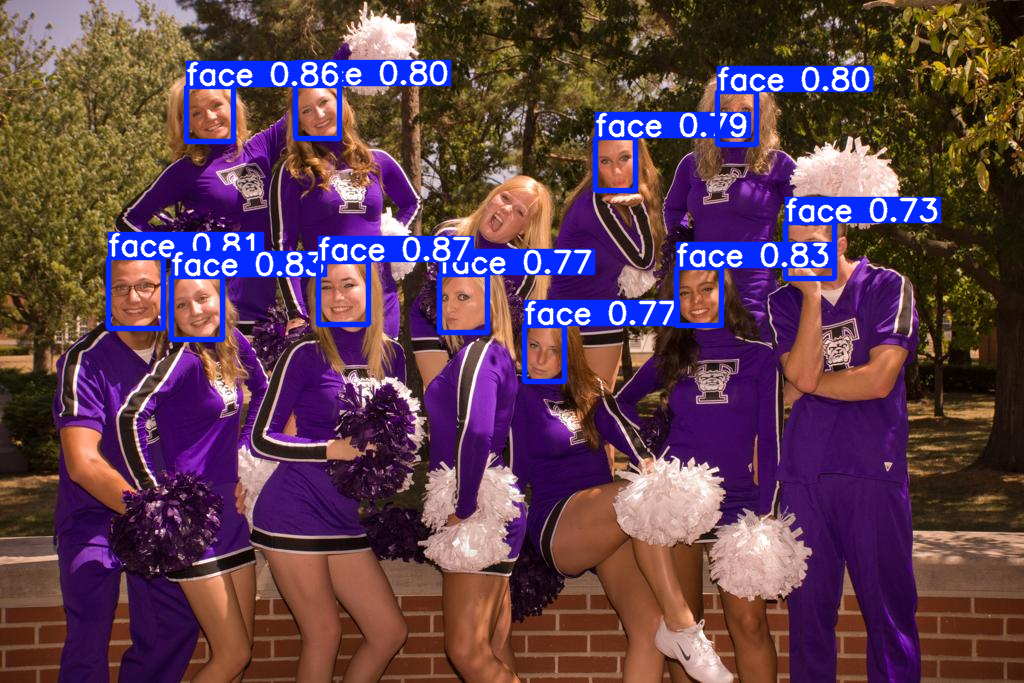

In [18]:

model_path = './runs/detect/yolov8n_widerface_run/weights/best.pt'

image_to_test = '7_Cheering_Cheering_7_119.jpg'

# Load the model
model = YOLO(model_path)

# Run inference
results = model(image_to_test)

results[0].show()

In [14]:
# Fine tuned downloaded from mentioned github repo
model_path = 'yolov8n_100e.pt'

# Load the model
model = YOLO(model_path)

print("\n--- Starting Evaluation ---\n")
metrics = model.val()
print("\n--- Evaluation Finished ---\n")

# 4. Print the key metrics
print("Key Evaluation Metrics:")
print(f"  mAP50-95 (Box): {metrics.box.map:.4f}")
print(f"  mAP50 (Box):    {metrics.box.map50:.4f}")


--- Starting Evaluation ---

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2961.5±553.5 MB/s, size: 241.1 KB)


val: Scanning /content/datasets/widerface_yolo/val/labels.cache... 2573 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2573/2573 [00:00<?, ?it/s]

val: /content/datasets/widerface_yolo/val/images/2_Demonstration_Protesters_2_231.jpg: 1 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 161/161 [00:38<00:00,  4.18it/s]


                   all       2573      29532      0.825      0.545      0.615      0.335
Speed: 0.3ms preprocess, 3.3ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/val3

--- Evaluation Finished ---

Key Evaluation Metrics:
  mAP50-95 (Box): 0.3352
  mAP50 (Box):    0.6146



image 1/1 /content/7_Cheering_Cheering_7_119.jpg: 448x640 11 Faces, 10.9ms
Speed: 3.5ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


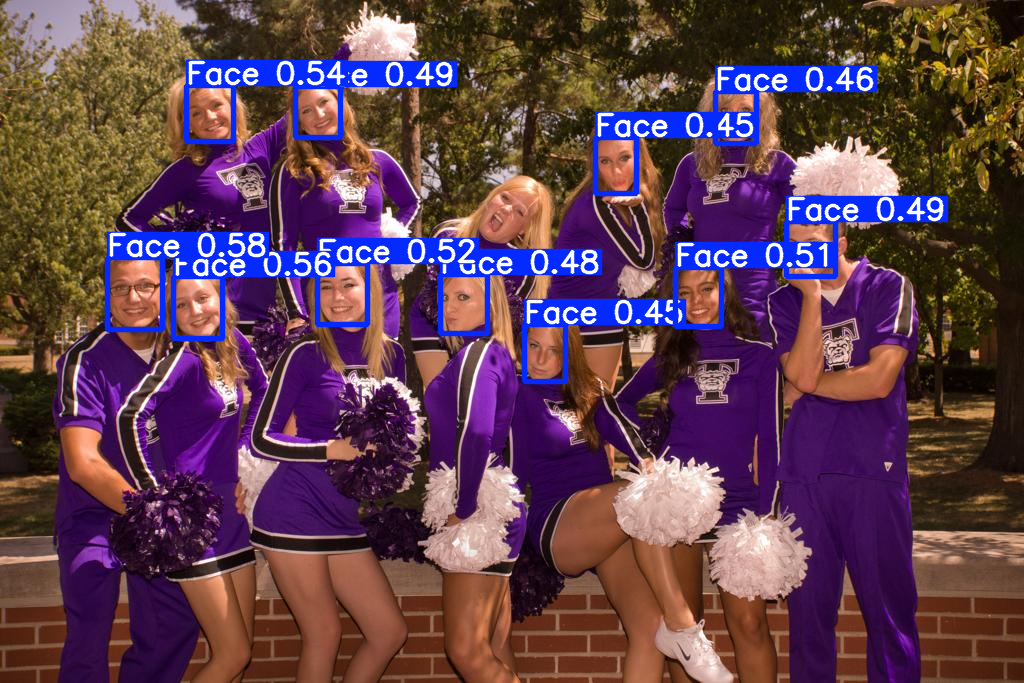

In [ ]:
# Fine tuned model downloaded from mentioned github repo
model_path = 'yolov8n_100e.pt'

# Load the model
model = YOLO(model_path)

results = model(image_to_test)

results[0].show()